In [3]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.python.ops import array_ops

from influence.plot_utils import show_graph
from models.regularized_regression import RegularizedRegression

## Derivation for Ridge Regression

Suppose $x^{1\times p}, X^{n\times p}, y^{n\times 1}, C^{1\times 1}$.
$$
\begin{split}
R_{emp} = \frac{1}{n}\left[(y-X\beta)^{\top} (y-X\beta)+ C\beta^T\beta\right] \qquad&(1\times 1) \\
\nabla^2_{\beta}R_{emp} = \frac{2}{n}(X^{\top}X +CI_p) \qquad&(p\times p)
\end{split}
$$
For some fixed validation or training point $z = (x,y)$
$$
\begin{split}
L(z;\hat{\beta}) = (y-x\hat{\beta})^{\top} (y-x\hat{\beta})+\frac{C}{n}\beta^T\beta \qquad&(1\times 1)\\
\nabla_{\beta}L(z;\hat{\beta}) = -2x^{\top} (y-x\hat{\beta})+\frac{2C}{n}\hat{\beta}\qquad&(p\times 1)\\
p = (\nabla^2_{\beta}R_{emp})^{-1}\nabla_{\beta}L(z_{te};\hat{\beta})\qquad&(p\times 1), \text{ Hessian-vector product}\\
u := \nabla_{\beta}L(z_{tr})=-2x_{tr}^{\top}(y_{tr}-x_{tr}\hat{\beta})+\frac{2C}{n}\hat{\beta} \qquad&(1\times p), \text{ Gradient of loss of 1 training point}\\
\mathcal{I}_{loss}(\color{red}{z_{tr}}, \color{blue}{z_{te}}) = u^{\top}p = 2n\color{red}{(y_{tr}-x_{tr}\hat{\beta} + \frac{C}{n}\hat{\beta})^{\top}x_{tr}}(X^{\top}X + CI_{p})^{-1}\color{blue}{x_{te}^{\top}(y_{te}-x_{te}\hat{\beta}+\frac{C}{n}\hat{\beta})}\qquad&(1\times 1)
\end{split}
$$

In [4]:
df = pd.read_csv('data/lm_10.csv')
n = len(df)
X = df.values[:, 0:10]
y = df.values[:, -1].reshape(n, 1)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)
for data in [X_train, X_test, y_train, y_test]:
    print(data.shape)
n, p = X_train.shape

(80, 10)
(20, 10)
(80, 1)
(20, 1)


In [5]:
def I_loss_closed_form(X_tr, Y_tr, X_te, Y_te, C):
    n_tr, p = X_tr.shape
    n_te, _ = X_te.shape
    beta_hat = np.linalg.inv(
        X_tr.T.dot(X_tr) + C*np.eye(p)).dot(X_tr.T).dot(Y_tr)
    H_inv = (n_tr/2)*np.linalg.inv(X_tr.T.dot(X_tr) + C*np.eye(p))
    I_loss = np.zeros((n_tr, n_te))
    for i in range(n_tr):
        for j in range(n_te):
            x_tr, y_tr = X_tr[i:i+1,:], Y_tr[i:i+1,:]
            x_te, y_te = X_te[j:j+1,:], Y_te[j:j+1,:]
            grad_tr = -2*x_tr.T.dot(y_tr - x_tr.dot(beta_hat)) + (2*C/n_tr)*beta_hat
            grad_te = -2*x_te.T.dot(y_te - x_te.dot(beta_hat)) + (2*C/n_tr)*beta_hat
            I_loss[i,j] = grad_tr.T.dot(H_inv).dot(grad_te)
    return I_loss

c = 1
I_loss_cf = I_loss_closed_form(X_train, y_train, X_test, y_test, c)

In [7]:
tf.reset_default_graph()
model = RegularizedRegression(
    model_name='RegularizedRegression',
    eta=0.001, C=c)
model.fit(X_train, y_train, n_iter=15000)

Step 0: loss = 151.12817383 (0.039 sec)
Step 1000: loss = 6.05096722 (0.000 sec)
Step 2000: loss = 3.12288713 (0.000 sec)
Step 3000: loss = 2.92740321 (0.000 sec)
Step 4000: loss = 2.90613914 (0.000 sec)
Step 5000: loss = 2.90345740 (0.000 sec)
Step 6000: loss = 2.90310144 (0.000 sec)
Step 7000: loss = 2.90305257 (0.000 sec)
Step 8000: loss = 2.90304565 (0.000 sec)
Step 9000: loss = 2.90304422 (0.000 sec)
Step 10000: loss = 2.90304446 (0.000 sec)
Step 11000: loss = 2.90304422 (0.000 sec)
Step 12000: loss = 2.90304422 (0.000 sec)
Step 13000: loss = 2.90304446 (0.000 sec)
Step 14000: loss = 2.90304446 (0.000 sec)


RegularizedRegression(eta=0.001,C=1)

In [8]:
show_graph(tf.get_default_graph())

In [8]:
%%time
I_loss_bf = model.influence_loss(
    X_test, y_test, method='brute-force')

Fetch training loss gradients (0.064 sec)
CPU times: user 180 ms, sys: 10.6 ms, total: 191 ms
Wall time: 171 ms


In [9]:
abs_pct_error = 100*np.abs(
    I_loss_bf - I_loss_cf) / np.abs(I_loss_cf)
print("Absolute percentage error to closed form:")
for row in abs_pct_error:
    print([('%.3f' % x) + '%' for x in row])

Absolute percentage error to closed form:
['0.074%', '0.000%', '0.051%', '0.217%', '0.142%', '0.129%', '0.079%', '0.199%', '0.069%', '0.055%', '0.048%', '0.289%', '0.060%', '0.030%', '0.018%', '0.101%', '0.072%', '0.167%', '0.068%', '0.052%']
['0.002%', '0.068%', '0.027%', '0.236%', '0.081%', '0.111%', '0.004%', '0.233%', '0.128%', '0.023%', '0.072%', '0.251%', '0.013%', '0.043%', '0.056%', '0.007%', '0.056%', '0.124%', '0.008%', '0.045%']
['0.021%', '0.030%', '0.003%', '0.065%', '0.103%', '0.012%', '0.023%', '0.202%', '0.066%', '0.002%', '0.048%', '0.272%', '0.001%', '0.018%', '0.025%', '0.018%', '0.024%', '0.146%', '0.011%', '0.022%']
['0.279%', '0.132%', '0.382%', '0.088%', '0.247%', '3.318%', '0.795%', '0.293%', '0.458%', '0.267%', '2.761%', '0.344%', '0.310%', '0.123%', '0.675%', '0.147%', '0.505%', '0.390%', '0.388%', '0.172%']
['0.049%', '0.004%', '0.031%', '0.238%', '0.142%', '0.092%', '0.043%', '0.183%', '0.070%', '0.035%', '0.008%', '0.305%', '0.044%', '0.018%', '0.006%', '0.

## Test Against LOO

In [10]:
%%time
I_loss_loo = model.leave_one_out_refit(
    X_test, y_test, n_iter=1000)

LOO Fold 0: loss = 2.91540956 (0.434 sec)
LOO Fold 8: loss = 2.91751194 (0.428 sec)
LOO Fold 16: loss = 2.91752338 (0.424 sec)
LOO Fold 24: loss = 2.85169220 (0.438 sec)
LOO Fold 32: loss = 2.91684461 (0.424 sec)
LOO Fold 40: loss = 2.91123390 (0.419 sec)
LOO Fold 48: loss = 2.91668248 (0.428 sec)
LOO Fold 56: loss = 2.90105748 (0.426 sec)
LOO Fold 64: loss = 2.91730046 (0.423 sec)
LOO Fold 72: loss = 2.89167690 (0.422 sec)
CPU times: user 45.9 s, sys: 6.93 s, total: 52.8 s
Wall time: 34.3 s


In [11]:
def LOO_closed_form(X_tr, Y_tr, X_te, Y_te, C):
    n_tr, p = X_tr.shape
    n_te, _ = X_te.shape
    ridge_loss = lambda x,y,b: (y-x.dot(b))**2 + c*b.T.dot(b)/n_tr
    beta_hat = np.linalg.inv(
        X_tr.T.dot(X_tr)+C*np.eye(p)).dot(X_tr.T).dot(Y_tr)
    L_full = ridge_loss(X_te, Y_te, beta_hat)
    loss_diff = np.zeros((n_tr, n_te))
    for i in range(n_tr):
        rest_indices = [idx for idx in range(n_tr) if idx!=i]
        X_loo, Y_loo = X_tr[rest_indices, :], Y_tr[rest_indices, :]
        beta_loo = np.linalg.inv(
            X_loo.T.dot(X_loo)+C*np.eye(p)).dot(X_loo.T).dot(Y_loo)
        L_loo = ridge_loss(X_te, Y_te, beta_loo)
        loss_diff[i, :] = (L_full - L_loo).T
    return loss_diff

# closed form loo loss difference
loo_loss_cf = LOO_closed_form(X_train, y_train, X_test, y_test, c)

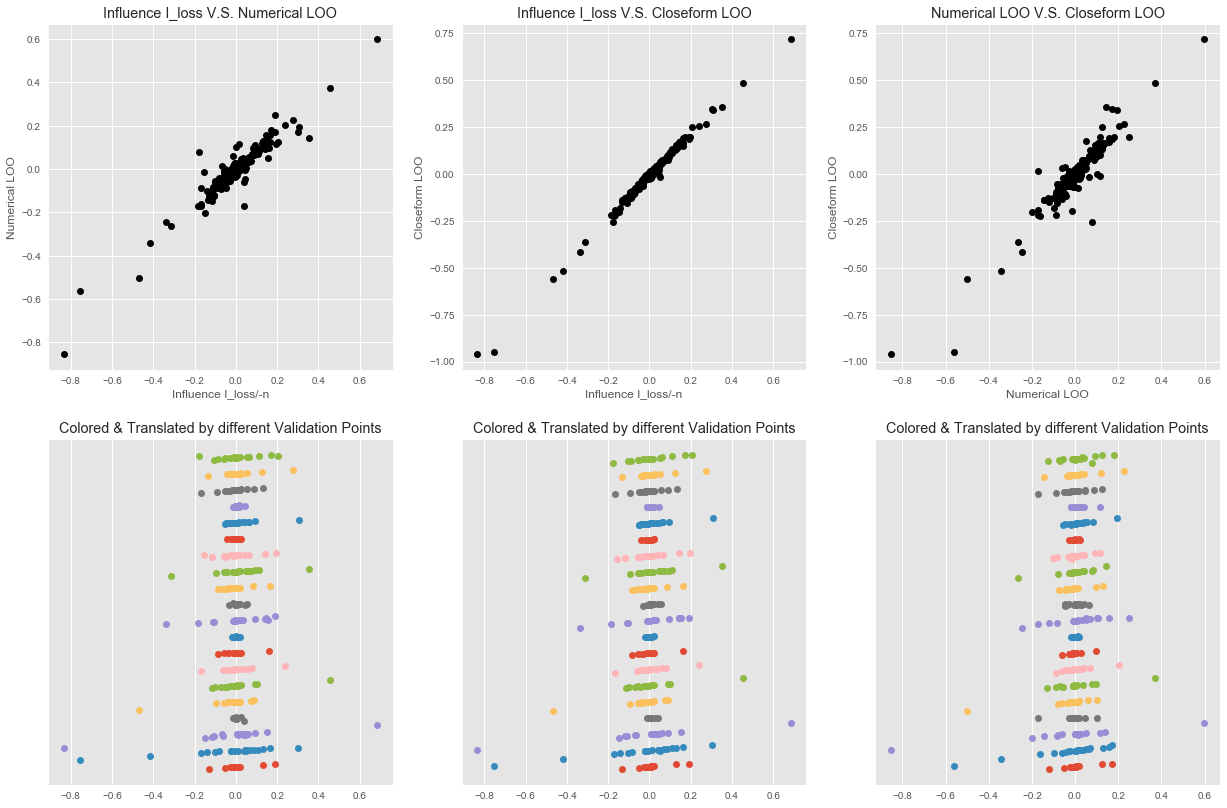

In [12]:
fig, axes = plt.subplots(2, 3 ,figsize=(21,14))
n_tr, _ = X_train.shape
n_te, _ = X_test.shape

for j in range(n_te):
    axes[0,0].plot(I_loss_bf[j,:]/(-n_tr), I_loss_loo[j,:], 
                 'o', color='black')
    axes[0,1].plot(I_loss_bf[j,:]/(-n_tr), loo_loss_cf[j,:], 
                 'o', color='black')
    axes[0,2].plot(I_loss_loo[j,:], loo_loss_cf[j,:], 
                 'o', color='black')
    
    axes[1,0].plot(I_loss_bf[j,:]/(-n_tr), I_loss_loo[j,:]+j, 'o')
    axes[1,1].plot(I_loss_bf[j,:]/(-n_tr), loo_loss_cf[j,:]+j, 'o')
    axes[1,2].plot(I_loss_loo[j,:], loo_loss_cf[j,:]+j, 'o')

axes[0,0].update({
    'title':'Influence I_loss V.S. Numerical LOO',
    'xlabel': 'Influence I_loss/-n',
    'ylabel': 'Numerical LOO'})
axes[0,1].update({
    'title':'Influence I_loss V.S. Closeform LOO',
    'xlabel': 'Influence I_loss/-n',
    'ylabel': 'Closeform LOO'})
axes[0,2].update({
    'title':'Numerical LOO V.S. Closeform LOO',
    'xlabel': 'Numerical LOO',
    'ylabel': 'Closeform LOO'})
axes[1,0].update({
    'title':'Colored & Translated by different Validation Points',
    'yticks': []})
axes[1,1].update({
    'title':'Colored & Translated by different Validation Points',
    'yticks': []})
_ = axes[1,2].update({
    'title':'Colored & Translated by different Validation Points',
    'yticks': []})

## Conjugate GD Approximation

In [16]:
%%time
I_loss_cg = model.influence_loss(
    X_test, y_test, method='cg')

Fetch training loss gradients (0.032 sec)
CG Objective: -8.15706
CG Objective: -8.304071
CG Objective: -8.310474
CG Objective: -8.3113365
CG Objective: -8.31153
CG Objective: -8.311531
         Current function value: -8.311531
         Iterations: 6
         Function evaluations: 154
         Gradient evaluations: 147
         Hessian evaluations: 12
CG Objective: -6.230044
CG Objective: -6.339347
CG Objective: -6.347693
CG Objective: -6.3488746
CG Objective: -6.348896
CG Objective: -6.3488975
Optimization terminated successfully.
         Current function value: -6.348897
         Iterations: 6
         Function evaluations: 84
         Gradient evaluations: 87
         Hessian evaluations: 12
CG Objective: -33.331562
CG Objective: -34.951187
CG Objective: -35.05409
CG Objective: -35.062077
CG Objective: -35.0628
CG Objective: -35.062885
CG Objective: -35.062893
         Current function value: -35.062893
         Iterations: 7
         Function evaluations: 76
         Gradient eval

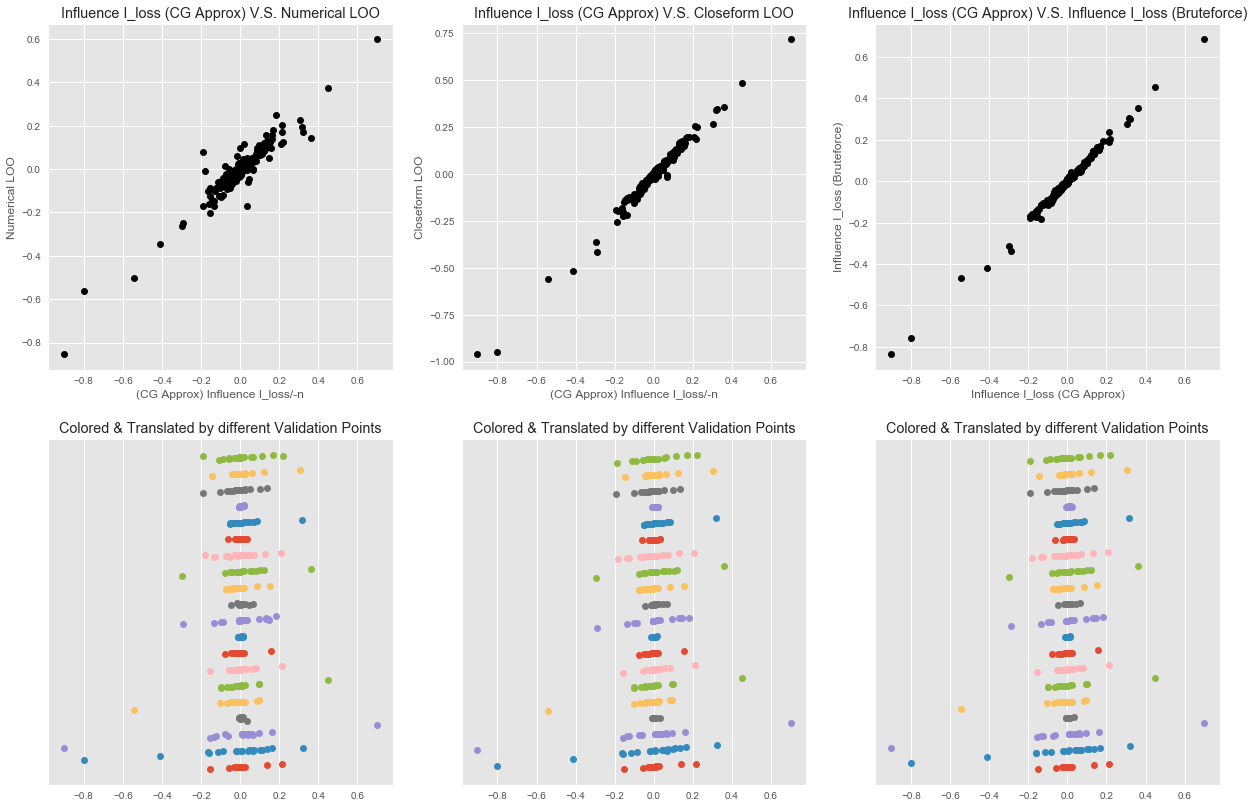

In [17]:
fig, axes = plt.subplots(2, 3 ,figsize=(21,14))
n_tr, _ = X_train.shape
n_te, _ = X_test.shape

for j in range(n_te):
    axes[0,0].plot(I_loss_cg[j,:]/(-n_tr), I_loss_loo[j,:], 
                 'o', color='black')
    axes[0,1].plot(I_loss_cg[j,:]/(-n_tr), loo_loss_cf[j,:], 
                 'o', color='black')
    axes[0,2].plot(I_loss_cg[j,:]/(-n_tr), I_loss_bf[j,:]/(-n_tr), 
                 'o', color='black')
    
    axes[1,0].plot(I_loss_cg[j,:]/(-n_tr), I_loss_loo[j,:]+j, 'o')
    axes[1,1].plot(I_loss_cg[j,:]/(-n_tr), loo_loss_cf[j,:]+j, 'o')
    axes[1,2].plot(I_loss_cg[j,:]/(-n_tr), I_loss_bf[j,:]/(-n_tr)+j, 'o')

axes[0,0].update({
    'title':'Influence I_loss (CG Approx) V.S. Numerical LOO',
    'xlabel': '(CG Approx) Influence I_loss/-n',
    'ylabel': 'Numerical LOO'})
axes[0,1].update({
    'title':'Influence I_loss (CG Approx) V.S. Closeform LOO',
    'xlabel': '(CG Approx) Influence I_loss/-n',
    'ylabel': 'Closeform LOO'})
axes[0,2].update({
    'title':'Influence I_loss (CG Approx) V.S. Influence I_loss (Bruteforce)',
    'xlabel': 'Influence I_loss (CG Approx)',
    'ylabel': 'Influence I_loss (Bruteforce)'})
axes[1,0].update({
    'title':'Colored & Translated by different Validation Points',
    'yticks': []})
axes[1,1].update({
    'title':'Colored & Translated by different Validation Points',
    'yticks': []})
_ = axes[1,2].update({
    'title':'Colored & Translated by different Validation Points',
    'yticks': []})